In [106]:
import pypsa
import pandas as pd
import numpy as np
import os
import pypsatopo
from xlsxwriter import Workbook

In [108]:
solver = "cbc"

In [110]:
# Create empty PyPSA network
n = pypsa.Network()

In [112]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2019", "01-01-2020", freq="h", inclusive="left")
n.set_snapshots(snapshots)

In [114]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [116]:
#Removal of certain components

#n.remove(class_name="Link", name="electricity_flow")
#n.remove(class_name="Bus", name="electricity_storage")

<Axes: xlabel='snapshot'>

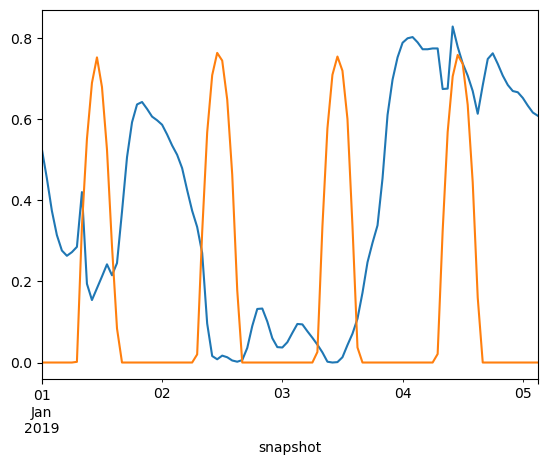

In [498]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("/data/JiLi_BC_wind_VE.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern), index=n.snapshots)

# Import an example of solar daily pattern
solar_pattern = pd.read_csv("/data/JiLi_BC_PV.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern), index=n.snapshots)

# Import an example of wind daily pattern
#load_pattern = pd.read_csv("data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
#load_profile = pd.Series(list(load_pattern)*365, index=n.snapshots)

# Print first few values to verify
wind_profile.head(100).plot()
solar_profile.head(100).plot()

In [499]:
# create the buses needed for the methanol system
n.add(class_name="Bus", name="electricity", carrier="electricity", overwrite=True)

#n.add(class_name="Bus", name="electricity_storage", carrier="electricity", overwrite=True)

# hydrogen buses
n.add(class_name="Bus", name="hydrogen", carrier="hydrogen", overwrite=True)
n.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen", overwrite=True)
# methanol buses
n.add(class_name="Bus", name="methanol", carrier="methanol", overwrite=True)
n.add(class_name="Bus", name="methanol_storage", carrier="methanol", overwrite=True)

n.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
methanol,1.0,,0.0,0.0,methanol,,1.0,0.0,inf,PQ,,
methanol_storage,1.0,,0.0,0.0,methanol,,1.0,0.0,inf,PQ,,


In [500]:
#create the end demand load for methanol

#n.remove(class_name="Load", name="hydrogen_load")
n.add(class_name="Load", name="methanol_load", bus="methanol", p_set=100, overwrite=True) 
#n.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100, carrier="hydrogen", type="hydrogen_load", overwrite=True)
# or p_set=load_profile
n.loads


,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
methanol_load,methanol,,,100.0,0.0,-1.0,True


In [501]:
#exchange rates
eur_to_usd = 1.1
usd_to_cny = 7.0774

# interest rate / discount rate
interest = 0.0563 # according to BOA PTX; original value: 0.05

In [502]:
# create the generators for wind, based on techno-economic parameters
# Onshore Wind's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 4500 * 1000 / usd_to_cny # $/MW
FOM = 2 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="wind",
    p_nom_extendable=True,
    p_nom_min=100, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile, 
    overwrite=True
)

Index(['onshore_wind'], dtype='object', name='Generator')

In [503]:
# create the generator for solar, based on techno-economic parameters
# Solar's techno-economic parameters are given as:
lifetime = 25
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 3940 * 1000 / usd_to_cny # $/MW
FOM = 1 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="solar",
    p_nom_extendable=True,
    p_nom_min=50,
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile, 
    overwrite=True
)

Index(['solar'], dtype='object', name='Generator')

In [504]:
#create the generator for hybrid supply

#n.add(class_name="Generator", name="hybrid_wind_solar", bus="electricity", carrier="wind", overwrite=True)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,0.0,0.0,True,100.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,0.0,0.0,True,50.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [505]:
# create hydrogen storage tank

#Techno-economic data for hydrogen storage tank
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 59.7 * 1000 # $/MWh (based on H2 compressed storage tank DTU data); original value: 4779.9527
FOM = 0.43 #%/year; unchanged

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
      class_name="Store",
      name="hydrogen_tank",
      type="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      capital_cost=annualized_capex + FOM/100 * annualized_capex,
      e_nom_extendable=True,
      e_cyclic=True,
      marginal_cost=1,#$/MWh 
      overwrite=True
)


Index(['hydrogen_tank'], dtype='object')

In [506]:
# create methanol storage tank

# Methanol tank's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.0563

CAPEX = 166.8201 * eur_to_usd # $/MWh
FOM = 4.0 # %/year

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name="Store", 
    name="methanol_tank",
    type="methanol_tank",
    bus="methanol_storage", 
    carrier="methanol",
    e_nom_extendable=True,
#    e_nom_max=5000,
    e_cyclic=False,
#    e_initial=0,
    capital_cost= annualized_capex * FOM/100 * annualized_capex,
    marginal_cost=1, 
    overwrite=True
)

n.stores

,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
hydrogen_tank,hydrogen_storage,hydrogen_tank,hydrogen,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,5071.388888,0.0,True,0,inf,0.0
methanol_tank,methanol_storage,methanol_tank,methanol,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,9.636523,0.0,True,0,inf,0.0


In [507]:
# Techno-economic parameters of a lithium ion battery storage:

lifetime = 12.5  # years (average: 10-15); https://greencubes.com/in-the-news/why-lithium-is-taking-over-stationary-energy-storage/
interest = 0.0563  # unit: -
CAPEX = 160 * 1000  # $/MW; original: 600 # 80USD / kWh storage (Nov 2024), assuming 2Ah storages. Source: https://www.energy-storage.news/mind-blowing-bids-power-chinas-16gwh-bess-tender-state-owned-firms-market-share/
FOM = 1.5  # $/MW per year (between 1% and 2% of the CAPEX)
VOM = 0  # $/MWh
fuel_cost = 0  # $/MWh_th per unit water consumed
efficiency_store = 0.965  # assuming similar storing and discharging efficiencies #https://blog.discoverbattery.com/understanding-charging
efficiency_dispatch = 0.965  # assuming similar storing and discharging efficiencies

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="StorageUnit",
    name="battery",
    bus="electricity",
    marginal_cost= VOM + fuel_cost,
    capital_cost=annualized_capex + FOM/100 * annualized_capex,
    p_nom_extendable=True,
    efficiency_store=efficiency_store,
    efficiency_dispatch=efficiency_dispatch,
    p_max_pu=1,  # Discharging availability
    p_min_pu=-1,  # Charging availability
    max_hours=2,  # energy-to-power ratio assumption is 2Ah
#    state_of_charge_initial=100,
    overwrite=True
)


#LCOH MAP is behaving in the same way because hydrogen and ammonia storage are cheaper
# set p_min if you want to really use batteries.

Index(['battery'], dtype='object')

In [508]:
#create the links for electrolysers, methanol synthesis, electricity flow and hydrogen flow
"""
n.add(
    class_name="Link", 
    name="electricity_flow",
    bus0="electricity",
    bus1="electricity_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)
"""
n.add(
    class_name="Link", 
    name="hydrogen_flow",
    bus0="hydrogen",
    bus1="hydrogen_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.add(
    class_name="Link", 
    name="methanol_flow",
    bus0="methanol",
    bus1="methanol_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
electrolyser,electricity,hydrogen,,Electrolyser,0.59,True,0,20.0,0.0,0.0,...,0,1,0,0.30,0.300,0.150,1.0,325.542960,,1.00
methanol_synthesis,electricity,methanol,,methanol_synthesis,25.00,True,0,20.0,0.0,0.0,...,0,1,0,0.04,0.004,0.015,1.0,5.449852,hydrogen,-31.25
hydrogen_flow,hydrogen,hydrogen_storage,,,1.00,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.00
methanol_flow,methanol,methanol_storage,,,1.00,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.00


In [509]:
#create the link for the electrolyser

# Electrolyser's techno-economic parameters are given as:
lifetime = 20
interest = 0.05
#water_cost = 1.8 # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
#water_demand_ratio= 21 # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?

CAPEX = 600.34 * 1000 # $/MW
FOM = 2 # %/year or CAPEX
VOM = 0 # $/MWh variable
efficiency = 0.59
ramp_limit_up= 0.3 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_down = 0.3 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_start_up = 0.15 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

"""
# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] = 
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (33.33 / 1000) # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = 0.6 / 33.33  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency # unit: kWh_el/kWh_H2
new_efficiency = 1 / (specific_consumption_compressor + specific_consumption_electrolyser)

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable
"""
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
#annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

n.add(
    class_name="Link",
    name="electrolyser",
    carrier="Electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
#    p_min_pu=0.6, 
#    p_max_pu=1,
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

"""
p_min_pu=0.6, 
p_max_pu=1,
"""

'\np_min_pu=0.6, \np_max_pu=1,\n'

In [510]:
#create the link for the methanol synthesis

# methanol synthesis techno-economic parameters are given as:

lifetime = 20 # original value: 30
interest = 0.0563 # according to BOA PTX; original value: 0.05 

CAPEX = 1339.6 * 1000 # $/MW; original value: XXXX
FOM = 2.0 # %/year 
VOM = 7.460  # $/MWh_MeOh ($ / t CO2 from coal power CCS cost); original value: XXXX
electricity_input_ms = 0.040 #MWh_el/MWh_MeOH (0.142); original value: XXXX
hydrogen_input = 1.250 #MWh_H2/MWh_MeOh (includes efficiency losses); original value: 1.1484
ramp_limit_up= 0.04 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_down = 0.004  #MW/hour amended to same as ramp_limit_up Source #4: Bodke et al (2021) 
ramp_limit_start_up = 0.015 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)


annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name = "Link",
    name = "methanol_synthesis",
    bus0="electricity",
    bus1="methanol",
    bus2="hydrogen",
    p_nom_extendable=True,
    carrier="methanol_synthesis",
    efficiency=1 / electricity_input_ms,
    efficiency2=-hydrogen_input / electricity_input_ms,
    capital_cost=(annualized_capex + FOM/100 * annualized_capex) / electricity_input_ms,
    marginal_cost=VOM / electricity_input_ms,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

    

Index(['methanol_synthesis'], dtype='object')

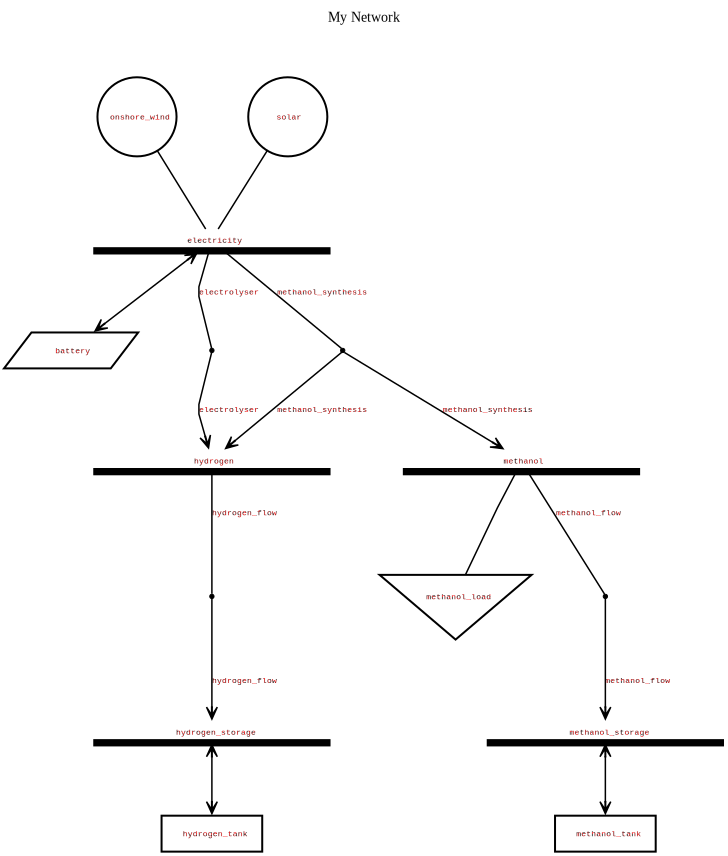

0

In [511]:
pypsatopo.generate(n)

# two outputs 
# Syngas CO + H2 + CO2 
# CO2 as an output 

In [512]:
# Solve network using cbc solver
n.optimize(pyomo=False, solver_name=solver)

Index(['hydrogen_flow', 'methanol_flow', 'electrolyser', 'methanol_synthesis'], dtype='object', name='Link')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'methanol',
       'methanol_storage'],
      dtype='object', name='Bus')
Index(['hydrogen_tank', 'methanol_tank'], dtype='object', name='Store')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_flow', 'methanol_flow', 'electrolyser', 'methanol_synthesis'], dtype='object', name='Link')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'methanol',
       'methanol_storage'],
      dtype='object', name='Bus')
Index(['hydrogen_tank', 'methanol_tank'], dtype='object', name='Store')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|████████████| 11/11 [00:00<00:00, 26.16it/s]
INFO:linopy.io: Writing time: 4.3

('ok', 'optimal')

In [513]:
n.stores_t.p

Store,hydrogen_tank,methanol_tank
snapshot,,
2019-01-01 00:00:00,0.000000,-17.973343
2019-01-01 01:00:00,18.495934,-17.973343
2019-01-01 02:00:00,41.712659,-17.973343
2019-01-01 03:00:00,59.125203,-17.973343
2019-01-01 04:00:00,70.153148,-17.973343
...,...,...
2019-12-31 19:00:00,-36.076426,14.621626
2019-12-31 20:00:00,-59.603946,15.093520
2019-12-31 21:00:00,-67.460176,15.565413


In [514]:
pd.concat([n.stores_t.e,n.stores_t.p],axis=1).head()


Store,hydrogen_tank,methanol_tank,hydrogen_tank,methanol_tank
snapshot,,,,
2019-01-01 00:00:00,2572.3384,17.973343,0.000000,-17.973343
2019-01-01 01:00:00,2553.8424,35.946686,18.495934,-17.973343
2019-01-01 02:00:00,2512.1298,53.920028,41.712659,-17.973343
2019-01-01 03:00:00,2453.0046,71.893371,59.125203,-17.973343
2019-01-01 04:00:00,2382.8514,89.866714,70.153148,-17.973343


In [515]:
n.generators.p_nom_opt

Generator
onshore_wind    491.87977
solar           426.63618
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

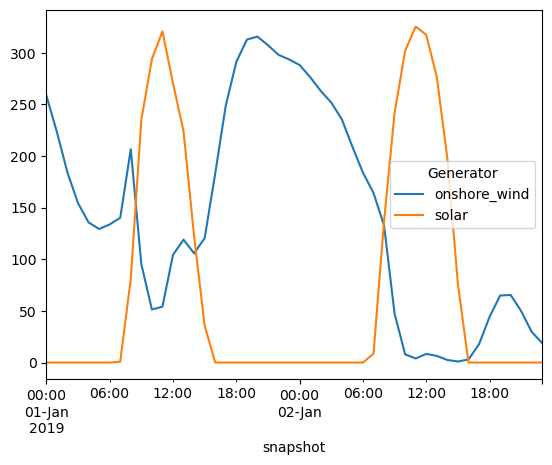

In [516]:
# Inspect the interaction of different power plants to supply loads
n.generators_t.p[:24*2].plot()

<Axes: xlabel='snapshot'>

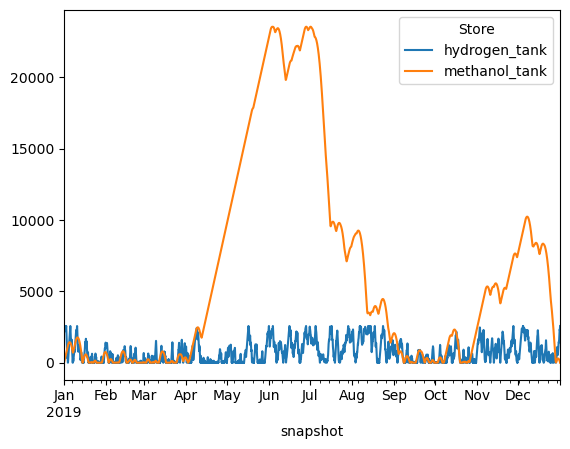

In [517]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
n.stores_t.e[:24*365].plot()

<Axes: xlabel='snapshot'>

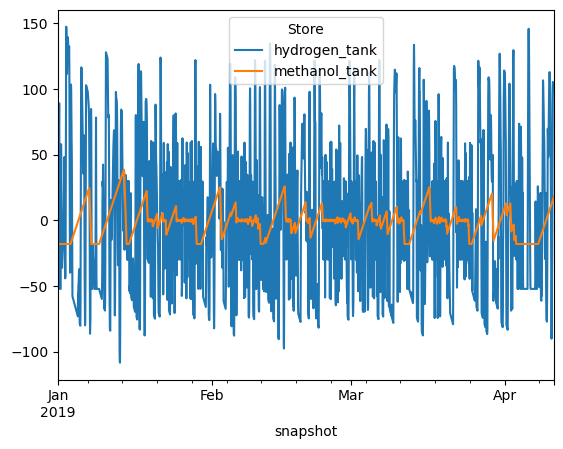

In [518]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
n.stores_t.p[:24*100].plot()

<Axes: xlabel='snapshot'>

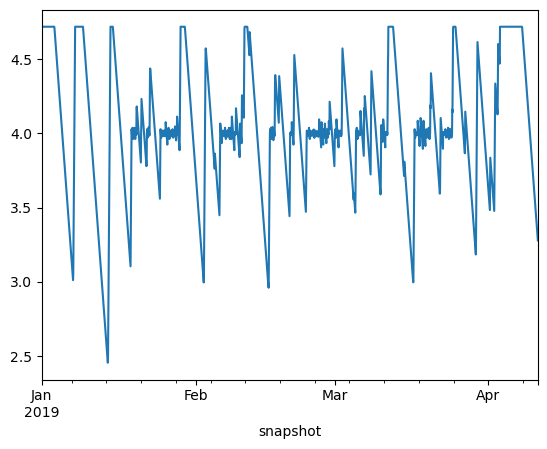

In [519]:
# Inspect the electrolysis input power
#n.links_t.p0["electrolyser"][:24*100].plot()

# Inspect the methanol synthesis input power
n.links_t.p0["methanol_synthesis"][:24*100].plot()

<Axes: xlabel='snapshot'>

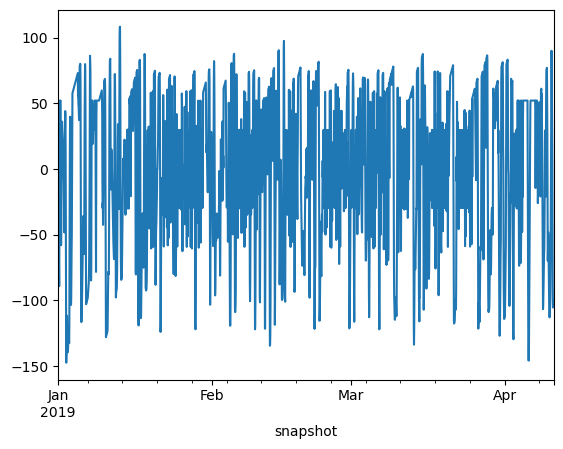

In [534]:
# Inspect the charging flow
n.links_t.p0["hydrogen_flow"][:24*100].plot()

<Axes: xlabel='snapshot'>

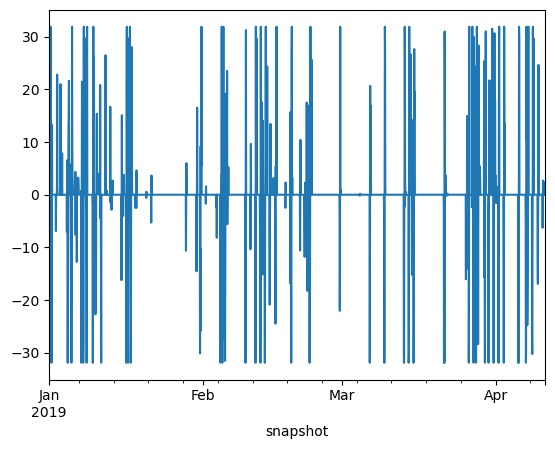

In [535]:
# Inspect the charging flow
n.storage_units_t.p["battery"][:24*100].plot()

<Axes: xlabel='snapshot'>

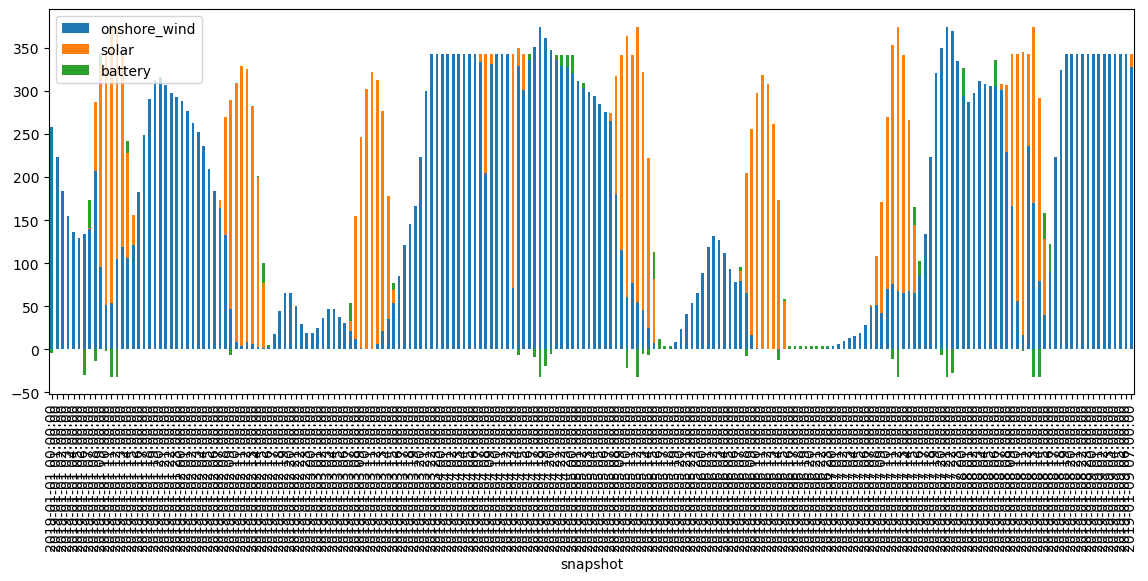

In [536]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)

plot = result.loc[
    :, ~result.columns.isin(["methanol_load"])
]  # drop load and nuclear columns
plot.iloc[:200, :].plot(kind="bar", stacked=True, figsize=(14, 5))

In [537]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   solar                      426.63618                 0.0   
            wind                       491.87977                 0.0   
Link        Electrolyser               338.29997                 0.0   
            hydrogen                   147.46668                 0.0   
            methanol                    76.36216                 0.0   
            methanol_synthesis           4.71893                 0.0   
Load        -                            0.00000                 0.0   
StorageUnit -                           31.91385                 0.0   
Store       hydrogen                  2572.33840                 0.0   
            methanol                 23544.88600                 0.0   

                                      Supply    Withdrawal  Energy Balance  \
Generator   solar               5.639762e+05  0.000000e+00    5.639762e+05   
            wind                1.327804e+06  0.000000e+00    1.327804e+06   
Link        Electrolyser        1.095000e+06  1.855932e+06   -7.609322e+05   
            hydrogen            3.917744e+05  3.917744e+05    0.000000e+00   
            methanol            1.226057e+05  1.226057e+05    0.000000e+00   
            methanol_synthesis  8.760000e+05  1.130040e+06   -2.540400e+05   
Load        -                   0.000000e+00  8.760000e+05   -8.760000e+05   
StorageUnit -                   1.094630e+04  1.175473e+04   -8.084315e+02   
Store       hydrogen            1.958872e+05  1.958872e+05    2.000000e-04   
            methanol            6.130287e+04  6.130287e+04   -4.000000e-04   

                                Transmission  Capacity Factor   Curtailment  \
Generator   solar                     0.0000         0.150903  140833.44727   
            wind                      0.0000         0.308156  331865.32331   
Link        Electrolyser              0.0000         0.626262       0.00000   
            hydrogen                 -0.0002         0.303276       0.00000   
            methanol                  0.0004         0.183286       0.00000   
            methanol_synthesis        0.0000         0.847650       0.00000   
Load        -                         0.0000              NaN       0.00000   
StorageUnit -                         0.0000         0.081201  280373.75747   
Store       hydrogen                  0.0000         0.289702       0.00000   
            methanol                  0.0000         0.270268       0.00000   

                                Capital Expenditure  Operational Expenditure  \
Generator   solar                      1.811074e+07             0.000000e+00   
            wind                       2.698280e+07             0.000000e+00   
Link        Electrolyser               1.662281e+07             0.000000e+00   
            hydrogen                   0.000000e+00            -2.000000e-04   
            methanol                   0.000000e+00             4.000000e-04   
            methanol_synthesis         1.363479e+07             6.534960e+06   
Load        -                          0.000000e+00             0.000000e+00   
StorageUnit -                          5.886054e+05             0.000000e+00   
Store       hydrogen                   1.304533e+07             2.000000e-04   
            methanol                   2.268908e+05            -4.000000e-04   

                                     Revenue  Market Value  
Generator   solar               1.811074e+07     32.112588  
            wind                2.698280e+07     20.321366  
Link        Electrolyser        1.662281e+07     15.180645  
            hydrogen           -1.800000e-04           NaN  
            methanol            4.000000e-04           NaN  
            methanol_synthesis  2.016975e+07     23.024824  
Load        -                  -9.574691e+07           NaN  
StorageUnit -                   5.886054e+05     53.771979  
Store       hydrogen            1.304533e+07     66.596130  
            methano

In [538]:
# Extract statistics
stats_df = n.statistics()

# Initialize a dictionary to store results
results = {}

# Sum total CAPEX
total_capex = stats_df["Capital Expenditure"].sum()
results["Total CAPEX"] = total_capex

# Sum total OPEX
total_opex = stats_df["Operational Expenditure"].sum()
results["Total OPEX"] = total_opex

# Methanol output
value = stats_df.loc[("Link", "methanol_synthesis"), "Supply"]
MW_to_t_conversion = (1 / 6.2)
m_output = value  # Adjusted as needed
results["Total Methanol Output"] = m_output

# Levelized Cost of Methanol (LCOM)
LCOM = ((total_capex + total_opex) / m_output) / MW_to_t_conversion
results["Total LCOM (USD/t)"] = LCOM

# Convert dictionary to DataFrame
df_results = pd.DataFrame(list(results.items()), columns=["Description", "Value"])

# Define the XLSX file path
xlsx_file_path = "/data/LCOM_PyPSA_results.xlsx"

# Combine both DataFrames into one DataFrame with section headers
with pd.ExcelWriter(xlsx_file_path, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
    # Write the statistics DataFrame
    writer.sheets["JiLi_BC_VE"] = None  # Ensure the sheet exists
    stats_df.to_excel(writer, sheet_name="JiLi_BC_VE", startrow=0, index=True)

    # Write the results summary below the statistics DataFrame
    df_results.to_excel(writer, sheet_name="JiLi_BC_VE", startrow=len(stats_df) + 3, index=False)

# Provide file path for download
print(f"Excel file saved at: {xlsx_file_path}")

MultiIndex([(  'Generator',              'solar'),
            (  'Generator',               'wind'),
            (       'Link',       'Electrolyser'),
            (       'Link',           'hydrogen'),
            (       'Link',           'methanol'),
            (       'Link', 'methanol_synthesis'),
            (       'Load',                  '-'),
            ('StorageUnit',                  '-'),
            (      'Store',           'hydrogen'),
            (      'Store',           'methanol')],
           )
Excel file saved at: /Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LCOM_PyPSA_results.xlsx


In [ ]:
# Exporting Methanol network
#n.export_to_netcdf("/path/netcdf_methanol.nc")

In [ ]:
"""
# notes
1. update numbers
1.1. update solar #check
1.2. update on_wind #check
1.3. update electrolyser #check (not sure if satisfactory, ramp up?)
1.4. update methanol_synthesis #check (not sure if satisfactory, ramp up?)
1.5. update hydrogen storage #check
1.6. update methanol tank ? 
1.7. update battery storage #check (better data available?) 

2. create new wind and solar profiles for China #check
2.1 ninja for wind #check
2.2 solar atlas for solar #check using 40 degree tilt

# questions: 
1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? 
1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?
2. both electrolyser and methanol_synthesis currently behave according to the intermittance of wind (and solar but less so) 
3. The battery seems to not connect, something seems wrong here. I do wonder if the unit for the capex shouldnt be MWh and not MW? 
4. How do I now determine the LCOA of the whole model? I haven't quite understood how that works.
"""

In [131]:
#References: 
#1- Agora Energiewende (2024). PyPSA Agora H2 Training. https://github.com/agoenergy/pypsa-agora-h2-training/tree/main
#2- Agora Energy Transition China (2025). China green LCO-X dataset. 
#3- wind and solar profiles: https://www.renewables.ninja/
#4 - Bodke, N., Pedersen, T. Andresen, G. (2021). Optimal Scheduling of Flexible Power-to-X Technologies in the Day-ahead Electricity Market. https://arxiv.org/pdf/2110.09800 